In [1]:
# import packages
import pandas as pd
import numpy as np

In [2]:
credit_card_df = pd.read_csv('creditcard.csv') # read data from the csv file
credit_card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Normalize and Scale data
#### Scale the data to similar magnitude 

In [3]:
from sklearn.preprocessing import StandardScaler

credit_card_df_norm = credit_card_df
credit_card_df_norm['Time'] = StandardScaler().fit_transform(credit_card_df_norm['Time'].values.reshape(-1, 1))
credit_card_df_norm['Amount'] = StandardScaler().fit_transform(credit_card_df_norm['Amount'].values.reshape(-1, 1))

### Train-Test split
#### The dataset is splitted to 80% traning data and 20% testing data. Random seed is used in order to produce the same data sets.

In [4]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42 
TEST_PCT = 0.2

X_train, X_test = train_test_split(credit_card_df_norm, test_size=TEST_PCT, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0] # normal transactions
X_train = X_train.drop(['Class'], axis=1) #drop the class column


Y_test = X_test['Class'] #save the class column for the test set
X_test = X_test.drop(['Class'], axis=1) #drop the class column

X_train = X_train.values #transform to ndarray
X_test = X_test.values

### Autoencoder model

In [5]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers

nb_epoch = 50
batch_size = 64
input_dim = X_train.shape[1] 
encoding_dim = 14
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Using TensorFlow backend.


In [6]:
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')

cp = ModelCheckpoint(filepath="fraud_detection_autoencoder.h5", save_best_only=True, verbose=0)

history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True, 
                          validation_data=(X_test, X_test), verbose=1, callbacks=[cp]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/50
227451/227451 [==============================] - 20s 88us/step - loss: 0.8363 - acc: 0.5271 - val_loss: 0.8062 - val_acc: 0.6283
Epoch 2/50
227451/227451 [==============================] - 19s 82us/step - loss: 0.7681 - acc: 0.6345 - val_loss: 0.7873 - val_acc: 0.6514
Epoch 3/50
227451/227451 [==============================] - 18s 78us/step - loss: 0.7463 - acc: 0.6576 - val_loss: 0.7678 - val_acc: 0.6638
Epoch 4/50
227451/227451 [==============================] - 17s 76us/step - loss: 0.7354 - acc: 0.6701 - val_loss: 0.7608 - val_acc: 0.6816
Epoch 5/50
227451/227451 [==============================] - 17s 76us/step - loss: 0.7294 - acc: 0.6844 - val_loss: 0.7562 - val_acc: 0.6910
Epoch 6/50
227451/227451 [==============================] - 18s 77us/step - loss: 0.7252 - acc: 0.6958 - val_loss: 0.7531 - val_acc: 0.7034
Epoch 7/50
227451/227451 [==============================] - 17s 74us/step - loss: 0.7219 - acc: 0.7046 - val_

### Evaluation and Plots

In [7]:
import matplotlib.pyplot as plt

plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

<Figure size 640x480 with 1 Axes>

In [8]:
X_test_predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': Y_test})

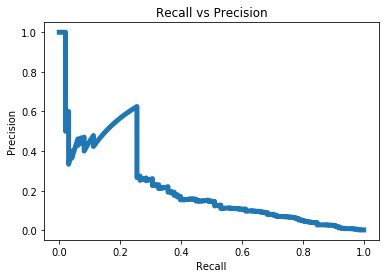

In [9]:
from sklearn.metrics import precision_recall_curve

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


#### While taking recall and precision into account, there is always a tradeoff if we want to miss a fraud data or flag a normal data as a fraudulent one.